<a href="https://colab.research.google.com/github/pb3lab/AI4PD_2025/blob/main/tutorials/mpnn/MPNN_teaching_notebook_ai4pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Protein Design using Message Passing Neural Networks (MPNNs)

Using LASErMPNN and Boltz-2.

<i> Created by Benjamin Fry - bfry@g.harvard.edu </i>

___

# 0) Install LASErMPNN and Boltz-2

### (Hit `Run all` -> Notebook will automatically restart once packages install -> Hit `Run all` again after restart).

Should take about 2 minutes.

In [1]:
# @title
%%capture
try:
  import torch
  import torch_scatter
  import torch_cluster

  if torch.__version__ != '2.8.0+cu126':
    raise ValueError

  import pykeops
  pykeops.test_numpy_bindings()
  pykeops.test_torch_bindings()

  print('Dependencies installed successfully! Installing LASErMPNN.')
  !git clone https://github.com/polizzilab/LASErMPNN.git --depth 1

except:
  !uv pip install --system "torch==2.8.0" scipy 'numpy<2.0.0' pandas scikit-learn h5py pytest prody matplotlib seaborn jupyter plotly pykeops logomaker wandb tqdm rdkit py3Dmol openbabel-wheel 'boltz[cuda]==2.2.1'
  !pip install torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

  import os
  os.kill(os.getpid(), 9)

In [2]:
# @title
%%capture

import os
import logging
import py3Dmol
import prody as pr
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
import numpy as np
import pandas as pd
sys.path.append('/content/LASErMPNN')
from utils.constants import aa_short_to_idx

pr.confProDy(verbosity='none')
logging.basicConfig(level=logging.DEBUG, filename='app.log', force=True)
logging.getLogger("prody").setLevel(logging.WARNING)

INFO:.prody:ProDy is configured: verbosity='none'


# 1) Let's begin by using [Boltz-2](https://github.com/jwohlwend/boltz) to predict the structure of the [ClpS protein](https://www.rcsb.org/structure/3DNJ) to study the effects of using Multiple Sequence Alignments (MSAs) for natural vs designed proteins.

In [3]:
clps_sequence = 'SLYRVLILNDDYTPMEFVVYVLERFFNKSREDATRIMLHVHQNGVGVCGVYTYEVAETKVAQVIDSARRHQHPLQCTMEKD'

# @markdown - Using the fasta input format, we can explicitly not use an MSA with Boltz by specifying the keyword `empty` after defining a protein chain A to run the prediction on (`>A|protein|empty`)
with open('test.fasta', 'w') as f:
  f.write(f'>A|protein|empty\n{clps_sequence}\n')

# @markdown - You can ask Boltz to ping the ColabFold server for an msa by passing the `--use_msa_server` flag after running the boltz predict command.
with open('test_usemsa.fasta', 'w') as f:
  f.write(f'>A|protein\n{clps_sequence}\n')

# @markdown - The `!` character in Colab notebooks indicates a command that would be run in the bash terminal on your laptop or an alternative shared compute server.
print("Running Boltz-2 now... This should take about 2 minutes.")
!boltz predict test.fasta
!boltz predict test_usemsa.fasta --use_msa_server

# Extract the pLDDT (Boltz Confidence) of the predicted strutures.
protein = pr.parseMMCIF('/content/boltz_results_test/predictions/test/test_model_0.cif')
reference_plddt = protein.ca.getBetas().mean()

protein = pr.parseMMCIF('/content/boltz_results_test_usemsa/predictions/test_usemsa/test_usemsa_model_0.cif')
reference_msa_plddt = protein.ca.getBetas().mean()

Running Boltz-2 now... This should take about 2 minutes.
Extracting the CCD data to /root/.boltz/mols. This may take a bit of time. You may change the cache directory with the --cache flag.
Checking input data.
Processing 1 inputs with 1 threads.
  0% 0/1 [00:00<?, ?it/s]Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
100% 1/1 [00:00<00:00,  2.98it/s]
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running structure prediction for 1 input.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.5.0
2025-10-30 19:34:31.295853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT 

In [4]:
# @title ### Now let's download the crystal structure of `ClpS` from the PDB.
if os.path.exists('3dnj.pdb'):
  !rm 3dnj.pdb

# Download the 3DNJ pdb file from the PDB.
!wget https://files.rcsb.org/download/3DNJ.pdb1.gz
!mv 3DNJ.pdb1.gz 3dnj.pdb.gz

# Decompress the downloaded file
!gunzip 3dnj.pdb.gz
!sed -i '/ D /d' 3dnj.pdb # Remove chain D (a small peptide that was crystallized with the ClpS protein which we will ignore.)
!sed -i '/HOH/d' 3dnj.pdb # Remove lines encoding waters

view = py3Dmol.view(width=1000)
view.addModel(open('./3dnj.pdb', 'r').read(),'pdb', keepH=True)
view.setStyle({'cartoon': {'colorscheme': 'whiteCarbon', 'opacity': 1.0}, 'stick': {'colorscheme': 'whiteCarbon'}})
view.setBackgroundColor('black')
view.zoomTo()
view.show()

--2025-10-30 19:36:33--  https://files.rcsb.org/download/3DNJ.pdb1.gz
Resolving files.rcsb.org (files.rcsb.org)... 65.8.76.69, 65.8.76.44, 65.8.76.58, ...
Connecting to files.rcsb.org (files.rcsb.org)|65.8.76.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: ‘3DNJ.pdb1.gz’

3DNJ.pdb1.gz            [ <=>                ]  48.04K   278KB/s    in 0.2s    

2025-10-30 19:36:34 (278 KB/s) - ‘3DNJ.pdb1.gz’ saved [49189]



3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Avg. C-alpha pLDDT:  53.715827160493824
C-alpha RMSD:  3.982016490235788


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

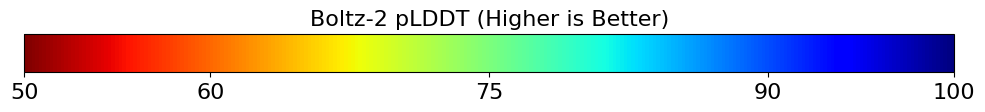

In [5]:
# @title # Visualize the Boltz-2 predicted structure of ClpS <u>without using MSAs</u> colored by pLDDT aligned to the structure of ClpS we downloaded from the PDB
# @markdown ### See the pLDDT and RMSD of the predicted structure below.
path_options = sorted(list(Path('/content/output/').glob('*.pdb')))

protein = pr.parseMMCIF('/content/boltz_results_test/predictions/test/test_model_0.cif')
path_to_visualize = f'/content/boltz_result.pdb'
pr.writePDB(path_to_visualize, protein)

ref_protein = pr.parsePDB('./3dnj.pdb')
protein = pr.calcTransformation(protein.select("chid A and name CA"), ref_protein.select('chid B and name CA')).apply(protein)
nomsa_rmsd = pr.calcRMSD(protein.select('chid A and name CA'), ref_protein.select('chid B and name CA'))

aligned_path = 'aligned_for_plot.pdb'
pr.writePDB(aligned_path, protein)
print()
print('Avg. C-alpha pLDDT: ', protein.ca.getBetas().mean())
print('C-alpha RMSD: ', nomsa_rmsd)

view = py3Dmol.view(width=1000)
view.addModel(open(aligned_path, 'r').read(),'pdb', keepH=True)
view.addModel(open('./3dnj.pdb', 'r').read(),'pdb', keepH=True)
view.setStyle({'model': 1}, {'cartoon': {'colorscheme': 'whiteCarbon', 'opacity': 0.7}})
view.setStyle({'model': 0}, {'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':100}}})
view.setBackgroundColor('black')
view.zoomTo()
view.show()

#### Plot horizontal color bar.
cmap = mpl.cm.jet_r
fig, ax = plt.subplots(figsize=(12, 0.5))
norm = mpl.colors.Normalize(vmin=50, vmax=100)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')

ticks = [50, 60, 75, 90, 100]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks, fontsize=16)

plt.title("Boltz-2 pLDDT (Higher is Better)", fontsize=16)
plt.show()


Avg. C-alpha pLDDT:  97.64756790123457
C-alpha RMSD:  0.36368772293694357


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

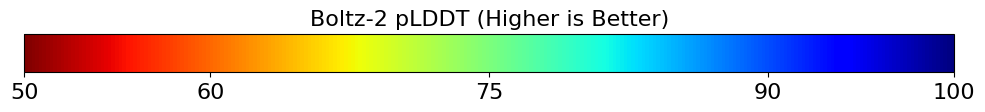

In [6]:
# @title # Visualize the Boltz-2 predicted structure of ClpS <u>using MSAs</u> colored by pLDDT aligned to the structure of ClpS we downloaded from the PDB
# @markdown ### See the pLDDT and RMSD of the predicted structure below.

protein = pr.parseMMCIF('/content/boltz_results_test_usemsa/predictions/test_usemsa/test_usemsa_model_0.cif')
path_to_visualize = f'/content/boltz_result.pdb'
pr.writePDB(path_to_visualize, protein)

ref_protein = pr.parsePDB('./3dnj.pdb')
protein = pr.calcTransformation(protein.select("chid A and name CA"), ref_protein.select('chid B and name CA')).apply(protein)
yesmsa_rmsd = pr.calcRMSD(protein.select('chid A and name CA'), ref_protein.select('chid B and name CA'))

aligned_path = 'aligned_for_plot.pdb'
pr.writePDB(aligned_path, protein)

print()
print('Avg. C-alpha pLDDT: ', protein.ca.getBetas().mean())
print('C-alpha RMSD: ', yesmsa_rmsd)

view = py3Dmol.view(width=1000)
view.addModel(open(aligned_path, 'r').read(),'pdb', keepH=True)
view.addModel(open('./3dnj.pdb', 'r').read(),'pdb', keepH=True)
view.setStyle({'model': 1}, {'cartoon': {'colorscheme': 'whiteCarbon', 'opacity': 0.7}})
view.setStyle({'model': 0}, {'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
view.setBackgroundColor('black')
view.zoomTo()
view.show()

#### Plot horizontal color bar.
cmap = mpl.cm.jet_r
fig, ax = plt.subplots(figsize=(12, 0.5))
norm = mpl.colors.Normalize(vmin=50, vmax=100)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
ticks = [50, 60, 75, 90, 100]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks, fontsize=16)
plt.title("Boltz-2 pLDDT (Higher is Better)", fontsize=16)
plt.show()

# 1.2) Now, let's use LASErMPNN to redesign the sequence of ClpS

In [7]:
# @markdown - To run LASErMPNN, we need an input pdb file containing the x,y,z coordinates of the protein backbone (N/C-alpha/C/O atoms).
# @markdown - We then need to specify a directory to output the designed sequences and predicted sidechain orientations with the designed sequences threaded onto them and the number of sequences to generate here we generate 10.

# Run python -m LASErMPNN.run_batch_inference --help for a list of all options, or check out the README page of the LASErMPNN GitHub
!python -m LASErMPNN.run_batch_inference 3dnj.pdb laser_outputs 10 -d cuda:0 --sequence_temp 0.001 2> /dev/null

# Read out the sequences generated by LASErMPNN.
seqs = []
for laser_output in Path('./laser_outputs/').glob('*.pdb'):
  seqs.append(pr.parsePDB(str(laser_output.absolute())).select('chid B and name CA').getSequence())

Processing 3dnj.pdb:
Generating 10 designs for 1 inputs with /content/LASErMPNN/model_weights/laser_weights_0p1A_nothing_heldout.pt on cuda:0 at temperature 0.001


In [8]:
# @title # Run Boltz-2 on the LASErMPNN-generated sequences
# Takes about 3 minutes.
opath = Path('./laser_output_boltz_inputs/')
opath.mkdir(exist_ok=True)

for idx, seq in enumerate(seqs):
  o = opath / f'design_{idx}.fasta'
  with open(o, 'w') as f:
    f.write(f'>A|protein|empty\n{seq}\n')

!boltz predict laser_output_boltz_inputs

Checking input data.
Processing 10 inputs with 2 threads.
  0% 0/10 [00:00<?, ?it/s]Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
 30% 3/10 [00:00<00:00, 21.90it/s]Found explicit empty MSA for some proteins, will run these in single sequence mode. Kee

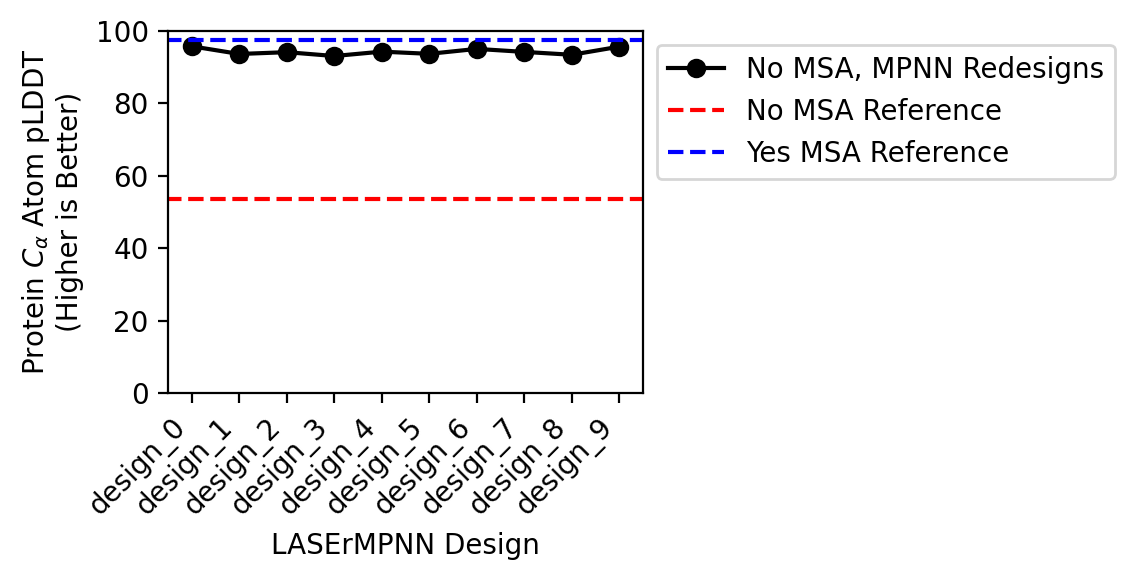

In [9]:
# @title # Compare the LASErMPNN Sequences predicted without MSAs to the natural sequence predicted without MSAs.

# Gather plddt confidences from the Boltz predictions.
design_name_to_plddt = {}
for cif in sorted(list(Path('./boltz_results_laser_output_boltz_inputs/').glob('predictions/*/*.cif'))):
  protein = pr.parseMMCIF(cif)
  design_name_to_plddt[cif.parent.name] = protein.ca.getBetas().mean()
fig, ax = plt.subplots(dpi=200, figsize=(5, 3))

# Compare the Boltz-2 confidences of the LASErMPNN sequences to the natural sequences.
ax.plot(range(len(design_name_to_plddt)), list(design_name_to_plddt.values()), '-ok', label='No MSA, MPNN Redesigns')
ax.set_ylim(0, 100)
ax.set_xlim(-0.5, 9.5)

ax.set_xticks(range(len(design_name_to_plddt)))
ax.set_xticklabels(list(design_name_to_plddt.keys()), rotation=45, ha="right")

ax.hlines(reference_plddt, -1, 10, 'r', label='No MSA Reference', linestyles='dashed')
ax.hlines(reference_msa_plddt, -1, 10, 'b', label='Yes MSA Reference', linestyles='dashed')
ax.set_ylabel('Protein $C_\\alpha$ Atom pLDDT\n(Higher is Better)')
ax.set_xlabel('LASErMPNN Design')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

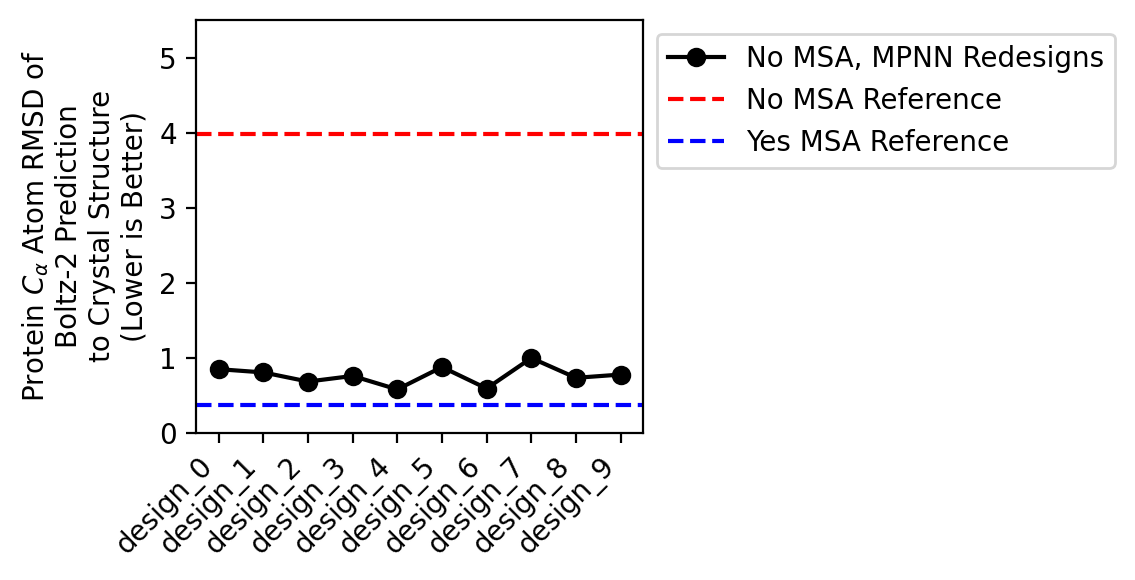

In [10]:
# @title
design_name_to_rmsd = {}
ref_protein = pr.parsePDB('./3dnj.pdb')
for cif in sorted(list(Path('./boltz_results_laser_output_boltz_inputs/').glob('predictions/*/*.cif'))):
  protein = pr.parseMMCIF(cif)
  protein = pr.calcTransformation(protein.select("chid A and name CA"), ref_protein.select('chid B and name CA')).apply(protein)
  design_name_to_rmsd[cif.stem.split('_model')[0]] = pr.calcRMSD(protein.select('chid A and name CA'), ref_protein.select('chid B and name CA'))

yesmsa_pred_protein = pr.parseMMCIF('/content/boltz_results_test_usemsa/predictions/test_usemsa/test_usemsa_model_0.cif')
yesmsa_pred_protein = pr.calcTransformation(yesmsa_pred_protein.select("chid A and name CA"), ref_protein.select('chid B and name CA')).apply(yesmsa_pred_protein)
yesmsa_rmsd = pr.calcRMSD(yesmsa_pred_protein.select('chid A and name CA'), ref_protein.select('chid B and name CA'))

fig, ax = plt.subplots(dpi=200, figsize=(5, 3))
ax.plot(range(len(design_name_to_rmsd)), list(design_name_to_rmsd.values()), '-ok', label='No MSA, MPNN Redesigns')
ax.set_ylim(0, max(5, nomsa_rmsd) + 0.5)
ax.set_xlim(-0.5, 9.5)
ax.set_xticks(range(len(design_name_to_rmsd)))
ax.set_xticklabels(list(design_name_to_rmsd.keys()), rotation=45, ha="right")
ax.hlines(nomsa_rmsd, -1, 10, 'r', label='No MSA Reference', linestyles='dashed')
ax.hlines(yesmsa_rmsd, -1, 10, 'b', label='Yes MSA Reference', linestyles='dashed')
ax.set_ylabel('Protein $C_\\alpha$ Atom RMSD of\nBoltz-2 Prediction\nto Crystal Structure\n(Lower is Better)')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show();

## Takeaways:

1) MPNN sequences are predicted (without MSAs) more confidently and lower RMSD than the natural sequence (without MSAs) so we do not need to use MSAs when evaluating our designs for "self-consistency" (whether the AlphaFold-predicted structure folds to the shape that the sequence was designed for). This is great because MSA generation can be computationally expensive!

2) Sequences generated by MPNNs are 'easier' for AlphaFold-like models to predict structures for--so "self-consistency" is a good way to filter for good designed sequences. MPNN generated sequences are typically hyper-thermostable as well. For an additional exercise, see if you can see why this is. Download the 3dnj.pdb and laser_outputs/design_0.pdb from the files tab on the left and compare the sequence composition in a tool like PyMol or ChimeraX (charged vs hydrophobic residue distribution, packing of the sidechains in the protein core, etc...)


# 2) Effect of MPNN Sampling Temperature

MPNN models are inherently random. Randomness comes from differences in decoding order (the order the protein residues are designed) and the conditional probability samplng process. We have a parameter which trades off the confidence of the model for sampling diversity called the `Temperature (T)` with the temperature-adjusted softmax formula shown below.

$$
P(z_i, T) = \frac{e^{z_i / T}}{\sum_{j=1}^{20} e^{z_j / T}}
$$

All MPNNs predict probabilities for each of the 20 natural amino acids for every residue in a protein structure given a current position in the protein at a given step in the randomly generated decoding order. [Here's a quick video explaining Temperature from 3Blue1Brown](https://youtube.com/shorts/XsLK3tPy9SI?si=sWQsx6x1UbP2ACe8) if you want to learn more. MPNNs work just like Large Language Models (LLMs) in the sense that they just predict probabilities for the next amino acid in a sequence of amino acids which we can sample from until the full protein is designed.


When using LASErMPNN above, we used a temperature around 0 (we can't use 0 exactly since this would mean we divide by zero in the formula above) since we only looked at a handful of designed sequences. A temperature near zero selects the most likely amino acid at each position. The only differences in the sequences generated by an MPNN at a low temperature are due to the differences in decoding order. Let's investigate the effect of sampling temperature on the sequences we get out of our sequence design MPNN model.

In [11]:
!rm -rf laser_outputs_temperature*
!rm -rf boltz_inputs_temperature_sweep/
!rm -rf boltz_results_boltz_inputs_temperature_sweep/

In [12]:
%%capture
# @title ### Start by generating 100 LASErMPNN sequences for ClpS at different temperatures
# @markdown Takes about 1 minute.
# The -b and -n flags increase the number of designs processed generated once by LASErMPNN, see the --help flag or README on GitHub to learn more.
path = Path('laser_outputs_temperature_0')
if not path.exists() or len(list(path.glob('*.pdb'))) != 100:
  !python -m LASErMPNN.run_batch_inference 3dnj.pdb laser_outputs_temperature_0 100 -b 100 -n 100 -d cuda:0 --sequence_temp 0.001

path = Path('laser_outputs_temperature_0p2')
if not path.exists() or len(list(path.glob('*.pdb'))) != 100:
  !python -m LASErMPNN.run_batch_inference 3dnj.pdb laser_outputs_temperature_0p2 100 -b 100 -n 100 -d cuda:0 --sequence_temp 0.2

path = Path('laser_outputs_temperature_0p5')
if not path.exists() or len(list(path.glob('*.pdb'))) != 100:
  !python -m LASErMPNN.run_batch_inference 3dnj.pdb laser_outputs_temperature_0p5 100 -b 100 -n 100 -d cuda:0 --sequence_temp 0.5

path = Path('laser_outputs_temperature_1p0')
if not path.exists() or len(list(path.glob('*.pdb'))) != 100:
  !python -m LASErMPNN.run_batch_inference 3dnj.pdb laser_outputs_temperature_1p0 100 -b 100 -n 100 -d cuda:0 --sequence_temp 1.0

path = Path('laser_outputs_temperature_1p5')
if not path.exists() or len(list(path.glob('*.pdb'))) != 100:
  !python -m LASErMPNN.run_batch_inference 3dnj.pdb laser_outputs_temperature_1p5 100 -b 100 -n 100 -d cuda:0 --sequence_temp 1.5

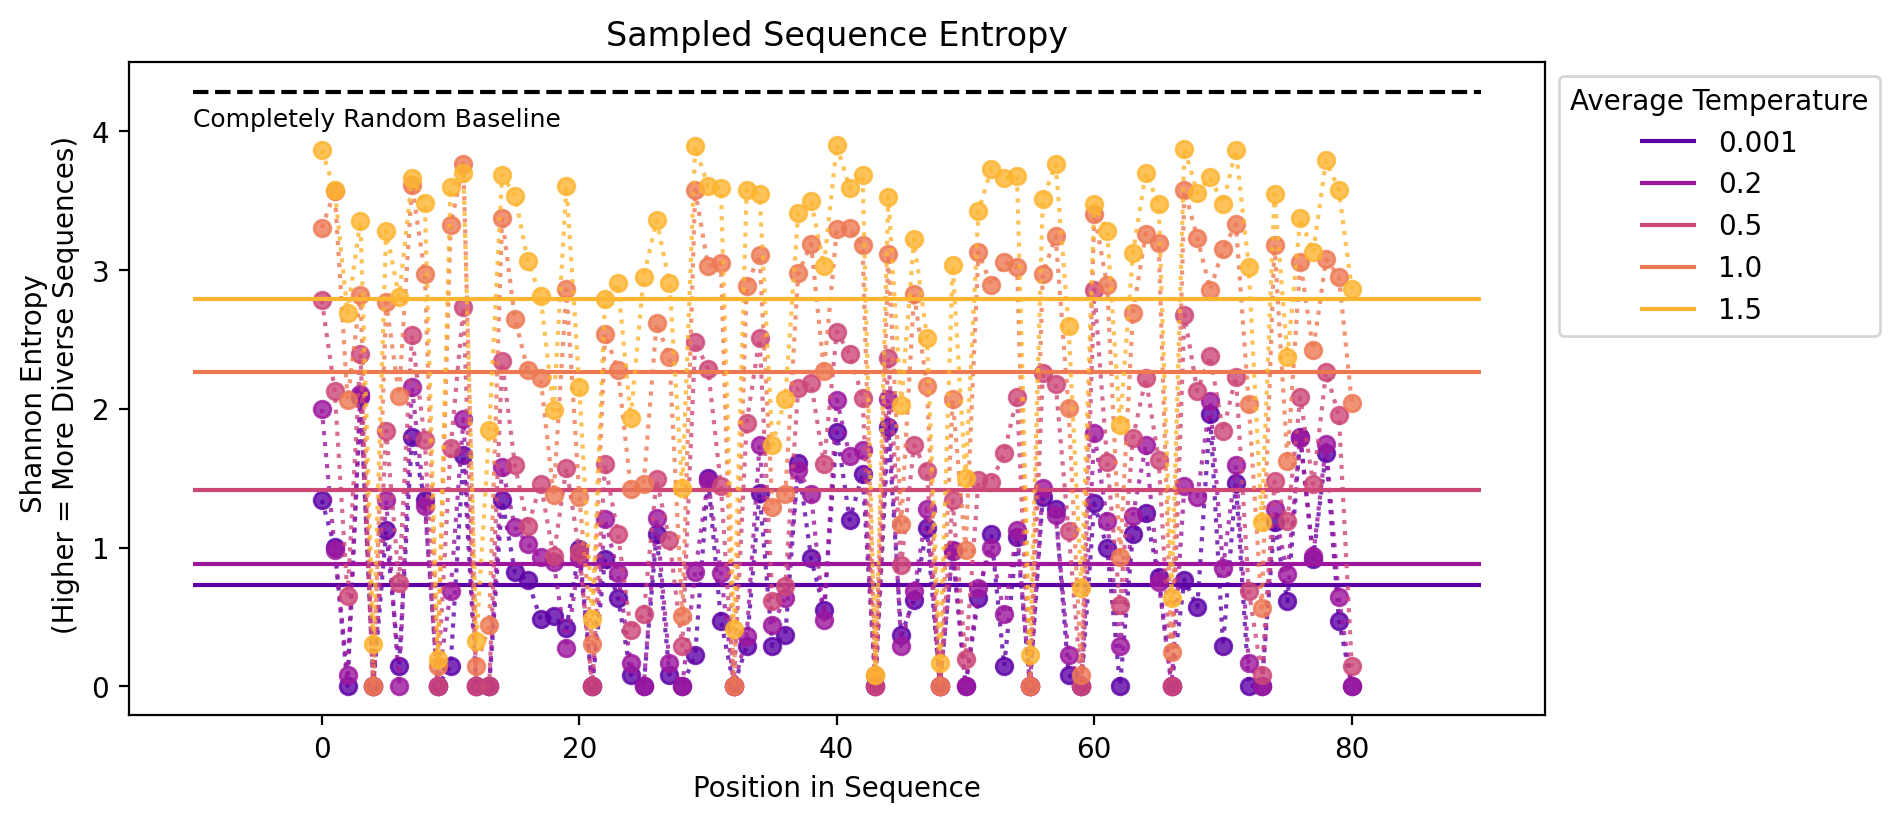

In [13]:
# @title ### Analyze the entropy of the sampled sequences
def calc_sampled_sequence_entropy(sequences):
  """Calculates the per-position entropy for a list of protein sequences."""
  positions_counts = np.zeros((len(sequences[0]), 20))
  for seq in sequences:
    for aa_idx, aa in enumerate(seq):
      positions_counts[aa_idx][aa_short_to_idx[aa]] += 1
  positional_freqs = (positions_counts / len(sequences)) + 0.00001
  positional_entropy = -1 * (positional_freqs * np.log2(positional_freqs)).sum(axis=-1)
  global_entropy = np.mean(positional_entropy)
  return positional_entropy, global_entropy

# Get completely random baseline
positions_counts = np.full((len(clps_sequence), 20), fill_value=(100 // 20))
positional_freqs = (positions_counts / len(clps_sequence)) + 0.00001
positional_entropy = -1 * (positional_freqs * np.log2(positional_freqs)).sum(axis=-1)
purely_random_baseline = np.mean(positional_entropy)

# Loop over all of the LASErMPNN designs and track the sequence entropy per residue across the 250 samples.
data = []
for path in sorted(Path('.').glob('laser_outputs_temperature_*/*.pdb'), key=lambda x: (x.parent, int(x.stem.split('_')[-1])) ):
  data.append({'parent_dir': path.parent.stem, 'design_index': int(path.stem.split('_')[-1]), 'sequence': pr.parsePDB(str(path.absolute())).select('chid B and name CA').getSequence()})
df_ = pd.DataFrame(data)
data = []
for gr, grdf in df_.groupby('parent_dir'):
  data.append({'temperature': gr.rsplit('_', 1)[-1], 'positional_entropy': calc_sampled_sequence_entropy(grdf.sequence.values)[0], 'global_entropy': calc_sampled_sequence_entropy(grdf.sequence.values)[1]})
df = pd.DataFrame(data)
df['temperature'] = df.temperature.map(lambda x: 0.001 if x == '0' else x.replace('p', '.'))
colors = sns.color_palette("plasma", n_colors=len(df))

# Plot positional entropy at different temperatures.
fig, ax = plt.subplots(dpi=200, figsize=(8, 4))
for idx, row in df.iterrows():
  ax.plot(range(len(row.positional_entropy)), row.positional_entropy, ':o', alpha=0.8, color=colors[idx],)
  plt.hlines(row.global_entropy, -10, 90, color=colors[idx], linestyles='solid', label=f'{row.temperature}')
plt.hlines(purely_random_baseline, -10, 90, color='black', linestyles='dashed')
plt.text(-10, purely_random_baseline - 0.25, 'Completely Random Baseline', fontsize=9)
plt.xlabel('Position in Sequence')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Average Temperature')
plt.tight_layout()
plt.ylabel('Shannon Entropy \n (Higher = More Diverse Sequences)')
plt.xlabel('Position in Sequence')
plt.title('Sampled Sequence Entropy')
plt.show();

In [14]:
%%capture

# @title ### Now, let's predict the structures of some of our designed sequences with Boltz and look at the effect of temperature on structural self-consistency.
# @markdown Takes about 6 minutes.
subset_df = df_[df_.design_index < 10].copy().reset_index(drop=True)
subset_df['temp'] = subset_df.parent_dir.map(lambda x: float(x.rsplit('_', 1)[-1].replace('p', '.')))

opath = Path('./boltz_inputs_temperature_sweep')
opath.mkdir(exist_ok=True)

for idx, row in subset_df.iterrows():
  o = opath / f'{row.parent_dir}-design_{row.design_index}.fasta'
  with o.open('w') as f:
    f.write(f'>A|protein|empty\n{row.sequence}\n')

# Reduce sampling steps by half of default to speed this up.
!boltz predict boltz_inputs_temperature_sweep --sampling_steps 100

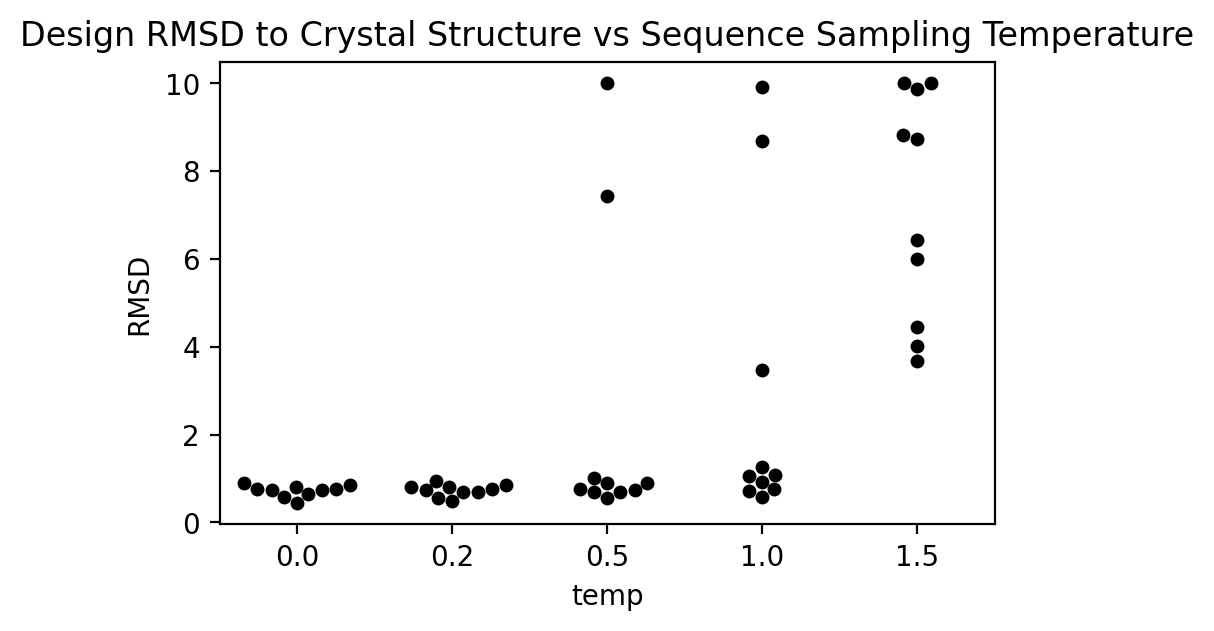

In [15]:
# @title ### We should see fewer self-consistent (low RMSD to crystal structure) designs as we increase the temperature.
# @markdown We typically use a temperature of around 0.2 to generate diverse sequences while ensuring designs are predicted to fold to the target structure. You can increase or decrease this depending on the number of designs you want to screen.
fig, ax = plt.subplots(dpi=200, figsize=(5, 3))
design_name_to_rmsd = {}
ref_protein = pr.parsePDB('./3dnj.pdb')
for cif in sorted(list(Path('./boltz_results_boltz_inputs_temperature_sweep/').glob('predictions/*/*.cif'))):
  protein = pr.parseMMCIF(cif)
  protein = pr.calcTransformation(protein.select("chid A and name CA"), ref_protein.select('chid B and name CA')).apply(protein)
  design_name_to_rmsd[cif.stem.split('_model')[0]] = pr.calcRMSD(protein.select('chid A and name CA'), ref_protein.select('chid B and name CA'))

df = pd.DataFrame(design_name_to_rmsd.items(), columns=['file_stem', 'RMSD'])

df.RMSD = df.RMSD.map(lambda x: min(10.0, x))
df['temp'] = df.file_stem.map(lambda x: float(x.split('-')[0].split('_')[-1].replace('p', '.')))
df = df.sort_values('temp')

sns.swarmplot(df, x='temp', y='RMSD', color='black', ax=ax)
ax.set_title('Design RMSD to Crystal Structure vs Sequence Sampling Temperature');

# 3) Ligand-Conditioned Protein Design

In [16]:
# @title ### Now let's download the crystal structure of the designed protein ABLE with PDB code `6w70` from the PDB.
# @markdown This protein is a de novo designed helical bundle that binds to the blood thinning drug Apixaban shown as magenta sticks.
if os.path.exists('6w70.pdb'):
  !rm 6w70.pdb

# Download the 3DNJ pdb file from the PDB.
!wget  https://files.rcsb.org/download/6W70.pdb1.gz
!mv 6W70.pdb1.gz 6w70.pdb.gz

# Decompress the downloaded file
!gunzip 6w70.pdb.gz
!sed -i '/SO4/d' 6w70.pdb # Remove lines encoding SO4 additive
!sed -i '/ACT/d' 6w70.pdb # Remove lines encoding ACT additive
!sed -i '/HOH/d' 6w70.pdb # Remove lines encoding waters

# Visualize Downloaded PDB file.
view = py3Dmol.view(width=1000)
view.addModel(open('./6w70.pdb', 'r').read(),'pdb', keepH=True)
view.setStyle({'cartoon': {'colorscheme': 'whiteCarbon', 'opacity': 1.0}, 'stick': {'colorscheme': 'whiteCarbon'}})
view.addStyle({'resn':'GG2'}, {'stick': {'colorscheme':'magentaCarbon'}})
view.setBackgroundColor('black')
view.zoomTo()
view.show()


--2025-10-30 19:49:12--  https://files.rcsb.org/download/6W70.pdb1.gz
Resolving files.rcsb.org (files.rcsb.org)... 65.8.76.69, 65.8.76.87, 65.8.76.44, ...
Connecting to files.rcsb.org (files.rcsb.org)|65.8.76.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: ‘6W70.pdb1.gz’

6W70.pdb1.gz            [  <=>               ]  62.60K   174KB/s    in 0.4s    

2025-10-30 19:49:13 (174 KB/s) - ‘6W70.pdb1.gz’ saved [64107]



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Now, let's run LASErMPNN on it.

LASErMPNN automatically detects ligand heteroatoms in the input PDB file and will use them when generating an amino acid sequence. You can explicitly tell it to ignore the ligand using the `--ignore_ligand` flag.

In [17]:
%%capture
if not Path('./laser_6w70_noligand/design_0.pdb').exists():
  !python -m LASErMPNN.run_batch_inference 6w70.pdb laser_6w70_noligand 1 --ignore_ligand

if not Path('./laser_6w70_useligand/design_0.pdb').exists():
  !python -m LASErMPNN.run_batch_inference 6w70.pdb laser_6w70_useligand 1

In [18]:
# @title ### Visualize LASErMPNN design <u>ignoring ligand</u>
# @markdown Notice how the model designs sidechains which pack the core of the protein.
# Visualize Downloaded PDB file.
view = py3Dmol.view(width=1000)
view.addModel(open('./laser_6w70_noligand/design_0.pdb', 'r').read(),'pdb', keepH=True)
view.setStyle({'cartoon': {'colorscheme': 'greenCarbon', 'opacity': 1.0}, 'stick': {'colorscheme': 'greenCarbon'}})
view.addStyle({'resn':'GG2'}, {'stick': {'colorscheme':'magentaCarbon'}})
view.setBackgroundColor('black')
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:

# @title ### Visualize LASErMPNN design <u>conditioned on ligand</u>
# @markdown Designed sidechains no longer clash with ligand and ideally form favorable hydrogen bonding interactions with ligand.
# Visualize Downloaded PDB file.
view = py3Dmol.view(width=1000)
view.addModel(open('./laser_6w70_useligand/design_0.pdb', 'r').read(),'pdb', keepH=True)
view.setStyle({'cartoon': {'colorscheme': 'greenCarbon', 'opacity': 1.0}, 'stick': {'colorscheme': 'greenCarbon'}})
view.addStyle({'resn':'GG2'}, {'stick': {'colorscheme':'magentaCarbon'}})
view.setBackgroundColor('black')
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.